# Wasserstein Barycenters of Gaussian Mixture Models

In this notebook we demonstrate how we can compute {class}`~ott.solvers.linear.continuous_barycenter.FreeWassersteinBarycenter` of mixtures of {class}`Gaussians <ott.tools.gaussian_mixture.gaussian.Gaussian>`.

In [1]:
import sys

if "google.colab" in sys.modules:
    !pip install -q git+https://github.com/ott-jax/ott@main

In [2]:
import jax
import jax.numpy as jnp
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from ott.geometry import costs
from ott.problems.linear import barycenter_problem
from ott.solvers.linear import continuous_barycenter
from ott.tools.gaussian_mixture import gaussian_mixture

## Generate the Gaussian Mixture Models

First, we randomly generate the $d$ dimensional mixtures of Gaussians. 

For each GMM we chose a ridge $c \in \mathbb{R}^d$ for the means of the components and a parameter $s>0$ that affects the covariance matrices of the components.

The means of the components of a GMM are generated as:

$$\mu = mu + c,$$

where $u$ is obtained as $d$ samples from the normal distribution, $c \in \mathbb{R}^d$ and $m=0.1\frac{1}{d} \sum_{i=1}^d c_i$. 

The covariance matrices are generated using the eigendecomposition:

$$C=U \Lambda U^{\top},$$

where $U \in \mathbb{R}^{d \times d}$ is a randomly generated orthogonal matrix and $\Lambda$ is the diagonal matrix with elements of the diagonal the randomly generated eigenvalues:

$$\lambda = s e^h,$$

where $h$ is obtained as $d$ samples from the normal distribution and $s>0$. 

The weights of the $K$ components of the GMM are generated as:

$$w_k = \frac{e^{a_k}}{\sum_{k=1}^K e^{a_k}} \forall k,$$

where $a_k=0.1*v_K$ and $v_k$ follows the normal distribution.

We generate three GMMs, each composed of a different number of components. 

In [3]:
dim = 2  # the dimension of the Gaussians
n_components = (2, 3, 5)  # the number of components of the GMMs
# the number of GMMs whose barycenter will be computed
n_gmms = len(n_components)
epsilon = 0.1  # the entropy regularization parameter

The barycentric weights determine how much each {class}`~ott.tools.gaussian_mixture.gaussian_mixture.GaussianMixture` will contribute to the {class}`~ott.solvers.linear.continuous_barycenter.FreeWassersteinBarycenter` computation. Since these weights must sum to one, we generate them by sampling Dirichlet random values. Larger values of the concentration parameter $\alpha$ lead to barycentric weights that are more uniform. Smaller values of $\alpha$ will result to certain GMMs contributing significantly more than others to the barycenter computation.   

In [4]:
# generate the pseudo-random keys that will be needed
key = jax.random.PRNGKey(seed=0)
keys = jax.random.split(key, num=3)

In [5]:
alpha = 50.0  # the concentration parameter of Dirichlet

In [6]:
barycentric_weights = jax.random.dirichlet(
    keys[0], alpha=jnp.ones(n_gmms) * alpha
)

In [7]:
# Create the seeds for the random generation of each measure.
seeds = jax.random.randint(keys[1], shape=(n_gmms,), minval=0, maxval=100)

We set the offsets $c$ for each GMM to be different so that they can be easily visualized.

In [8]:
# Offsets for the means of each GMM
cs = jnp.array([[-20, -15], [60, -15], [50, 65]])

In [9]:
cs.shape

(3, 2)

In [10]:
ms = 0.1 * jnp.mean(cs, axis=1)

In [11]:
# parameter that controls the covariance matrices
ss = jnp.array([4, 3, 5])

In [12]:
assert cs.shape[0] == n_gmms
assert ss.size == n_gmms
assert seeds.size == n_gmms
assert len(n_components) == n_gmms
assert jnp.mean(cs, axis=1).all() > 0
assert ss.all() > 0

In [13]:
gmm_generators = [
    gaussian_mixture.GaussianMixture.from_random(
        jax.random.PRNGKey(seeds[i]),
        n_components=n_components[i],
        n_dimensions=dim,
        stdev_cov=ss[i],
        stdev_mean=ms[i],
        ridge=cs[i],
    )
    for i in range(n_gmms)
]

In [14]:
# get the means and covariances of the GMMs
means_covs = [
    (gmm_generators[i].loc, gmm_generators[i].covariance) for i in range(n_gmms)
]

In [15]:
means_and_covs_to_x = jax.vmap(costs.mean_and_cov_to_x, in_axes=[0, 0, None])

In [16]:
# stack the concatenated means and (raveled) covariances of the pointclouds
ys = jnp.vstack(
    means_and_covs_to_x(means_covs[i][0], means_covs[i][1], dim)
    for i in range(n_gmms)
)

In [17]:
# get the weights of the randomly generated GMMs
weights = [gmm_generators[i].component_weight_ob.probs() for i in range(n_gmms)]

In [18]:
# stack the weights of the GMMs
bs = jnp.hstack(jnp.asarray(weights[i]) for i in range(n_gmms))

## Compute the Wasserstein barycenter of the GMMs

We can now compute the barycenter of the input GMMs. We determine the size of the barycenter and solve the barycenter problem. We must ensure that the initialization of the {class}`~ott.problems.linear.barycenter_problem.FreeBarycenterProblem` is such that its covariance matrices are positive semidefinite. We therefore initialize the barycenter as a random {class}`~ott.tools.gaussian_mixture.gaussian_mixture.GaussianMixture`.

In [19]:
# determine the size of the barycenter.
bar_size = 6

In [20]:
gmm_generator = gaussian_mixture.GaussianMixture.from_random(
    keys[2], n_components=bar_size, n_dimensions=dim
)

x_init_means = gmm_generator.loc
x_init_covs = gmm_generator.covariance

x_init = means_and_covs_to_x(x_init_means, x_init_covs, dim)

In [21]:
# create an instance of the Bures cost class.
b_cost = costs.Bures(dimension=dim)

In [22]:
# create a barycenter problem.
bar_p = barycenter_problem.FreeBarycenterProblem(
    y=ys,
    b=bs,
    weights=barycentric_weights,
    num_per_segment=n_components,
    cost_fn=b_cost,
    epsilon=epsilon,
)

In [23]:
# create a Wasserstein barycenter solver.
solver = continuous_barycenter.FreeWassersteinBarycenter(lse_mode=True)

In [24]:
# compute the barycenter.
out = solver(bar_p, bar_size=bar_size, x_init=x_init)
barycenter = out.x

Now that we have computed the barycenter, we can extract the means and the covariances of its components.

In [25]:
# extract the means and covariances of the barycenter.
means_bary, covs_bary = costs.x_to_means_and_covs(barycenter, dim)

## Visualize the results

We consider a discretization grid in 2D in order to plot the negative probabilities of points under the considered GMMs. 

In [26]:
# create the grid
x1 = np.linspace(-30.0, 90.0)
x2 = np.linspace(-30.0, 90.0)
x, y = np.meshgrid(x1, x2)
grid = np.array([x.ravel(), y.ravel()]).T

In [27]:
# compute the negative log probabilities of the GMMs at the grid.
n_log_probs = jnp.asarray(
    [-gmm_generators[i].log_prob(grid) for i in range(n_gmms)]
)

In [28]:
weights_bary = jnp.ones(bar_size) / bar_size

We now create a {class}`~ott.tools.gaussian_mixture.gaussian_mixture.GaussianMixture` object using the means and covarinces of the computed barycenter.

In [29]:
# compute the negative log probabilities at the grid under the barycenter GMM.
gmm_generator_bary = (
    gaussian_mixture.GaussianMixture.from_mean_cov_component_weights(
        mean=means_bary, cov=covs_bary, component_weights=weights_bary
    )
)

# compute the negative log probabilities of the barycenter at the grid.
n_log_prob_bary = -gmm_generator_bary.log_prob(grid)

We visualize the three GMMs and their barycenter by plotting the negative log probabilities at the considered grid.

In [30]:
# reshape the log probabilities in order to plot.
n_log_probs = n_log_probs.reshape((n_gmms, x.shape[0], x.shape[1]))
n_log_prob_bary = n_log_prob_bary.reshape((x.shape[0], x.shape[1]))

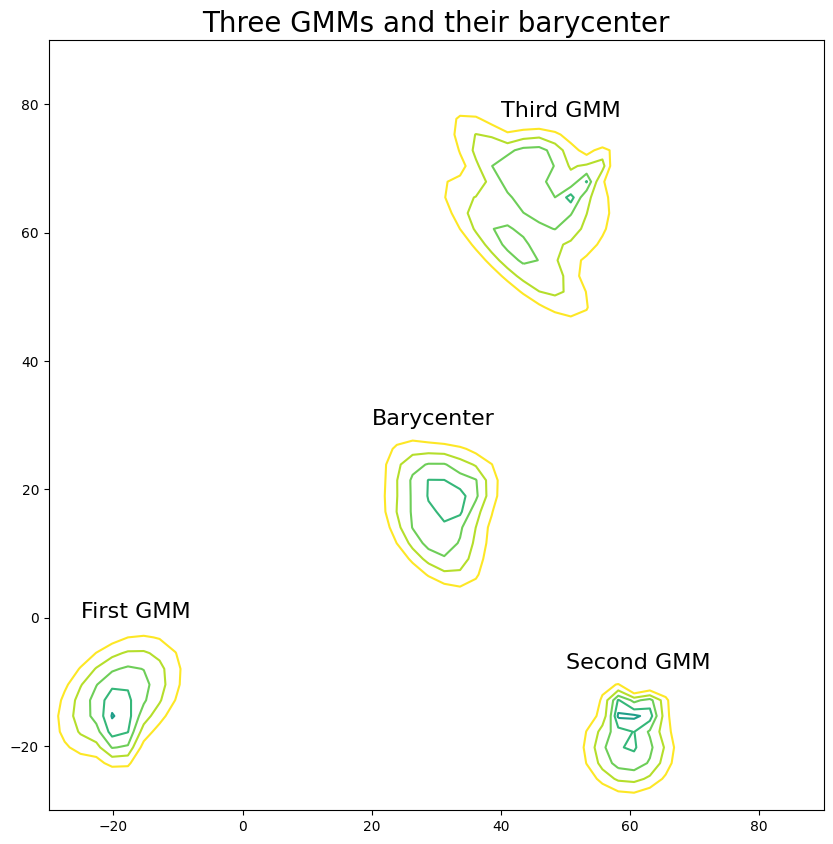

In [31]:
plt.figure(figsize=(10, 10))
for i in range(n_gmms):
    _ = plt.contour(
        x,
        y,
        n_log_probs[i, :, :],
        norm=LogNorm(vmin=1.0, vmax=10.0),
        levels=np.logspace(0, 1, 10),
    )
_ = plt.contour(
    x,
    y,
    n_log_prob_bary,
    norm=LogNorm(vmin=1.0, vmax=10.0),
    levels=np.logspace(0, 1, 10),
)
plt.annotate("First GMM", (-25, 0), fontsize=16)
plt.annotate("Second GMM", (50, -8), fontsize=16)
plt.annotate("Third GMM", (40, 78), fontsize=16)
plt.annotate("Barycenter", (20, 30), fontsize=16)

plt.title("Three GMMs and their barycenter", fontsize=20)
plt.axis("tight")
plt.show()